In [1]:
import sys

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib notebook
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np

##
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import normalize


#!{sys.executable} -m pip install tensorflow-gpu --user
#!{sys.executable} -m pip install keras --user
import tensorflow as tf
from keras import backend as k

import keras
from keras.optimizers import SGD
#!{sys.executable} -m pip install hyperas --user
#!{sys.executable} -m pip install networkx==1.11 --user

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

import os.path
import datetime

from dependencies import models
from dependencies import functions

from dependencies.convnet_drawer.convnet_drawer import Model
from dependencies.convnet_drawer.convnet_drawer import Conv2D
from dependencies.convnet_drawer.convnet_drawer import MaxPooling2D as MaxPooling2D_drawer
from dependencies.convnet_drawer.convnet_drawer import Flatten as Flatten_drawer
from dependencies.convnet_drawer.convnet_drawer import Dense as Dense_drawer
from dependencies.convnet_drawer.matplotlib_util import save_model_to_file
from dependencies.convnet_drawer.keras_util import convert_drawer_model

C:\Users\yurin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Import mfcc data

In [3]:
#choose which dictionary to use
choice = 'logfilter' # 'mfcc'#
useDelta = True
#retrieving of used values for the computation of mfcc
with open('variables/mfccValues.pkl', 'rb') as f:  
    values = pickle.load(f)
selected = 0
if choice == 'mfcc':
    
    
    
    #name format of the selected data
    if useDelta:
        name = 'variables/mfcc_D_DD_Dict[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    else:
        name = 'variables/mfccDict[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    #loading in usedDict of the mfcc dict
    #name = 'variables/mfcc_delta_deltadelta_PCA.pkl'
    with open(name, 'rb') as f: 
        usedDict = pickle.load(f)
    print('Loaded '+name)

elif choice == 'logfilter':
    name = 'variables/logfiltDict[nF='+str(values[selected][1])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    #saving in usedDict of the spectro dict
    with open(name, 'rb') as f:  
        usedDict = pickle.load(f)
    print('Loaded '+name)

Loaded variables/logfiltDict[nF=26 wL=0.025 wS=0.01].pkl


# Acquiring and scaling data

In [4]:
%%time
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = ['one', 'two', 'three','four','five','six','seven','eight','nine', "zero"]

words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

test = ["yes", "up", "down", "left"]#, "right", "on", "off", "stop", "go", "zero",
          # "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#selecting the subset of words
used = words

used.append('silence')
unknown = list(usedDict.keys())
for key in used:
    try:
        unknown.remove(key)
    except:
        print(key, ' not in used')

#divding between train and test with also scaling data
x_train, y_train, x_test, y_test, labelList = functions.train_test_creator(
    {k: usedDict[k] for k in usedDict.keys() & used },
    {k: usedDict[k] for k in usedDict.keys() & unknown },
    with_unknown = True,
    scalerType = 'robust',
    depth = 3)


{'copy': True, 'quantile_range': (25.0, 75.0), 'with_centering': True, 'with_scaling': True}
{'copy': True, 'quantile_range': (25.0, 75.0), 'with_centering': True, 'with_scaling': True}
{'copy': True, 'quantile_range': (25.0, 75.0), 'with_centering': True, 'with_scaling': True}
Wall time: 1min 20s


# Fitting

In [5]:

# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.9
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

epoch = 40
epochSGD = 20

dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
cnn = models.model1(x_train,y_train, depth = 3)
print("Model1")
cnn.summary()

cnn = models.model2(x_train,y_train, depth = 3)
print("Model2")
cnn.summary()

cnn = models.model3(x_train,y_train, depth = 3)
print("Model3")
cnn.summary()

cnn = models.tinyDarknet(x_train,y_train, depth = 3)
print("tiny darknet")
cnn.summary()

In [31]:
%%time

print("MODEL1")
cnn = models.model1(x_train,y_train, depth = x_train.shape[3])

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/300),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/300), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width


plt.show()

name = 'cnn1.bak'
cnn.save(dest_directory + name)

MODEL1


ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_31/convolution' (op: 'Conv2D') with input shapes: [?,28,1,128], [4,3,128,256].

In [32]:
%%time
print("\nMODEL3")
cnn = models.model3(x_train,y_train, depth = 3, basedim = 32)

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/200),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/200), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn3.bak'
cnn.save(dest_directory + name)


MODEL3


ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_35/MaxPool' (op: 'MaxPool') with input shapes: [?,12,1,128].


TINYDARKNET
Train on 40451 samples, validate on 10113 samples
Epoch 1/40
40451/40451 [==============================] - 23s 558us/step - loss: 2.1233 - acc: 0.4938 - val_loss: 0.7479 - val_acc: 0.8186
Epoch 2/40
40451/40451 [==============================] - 16s 401us/step - loss: 0.5894 - acc: 0.8340 - val_loss: 0.4766 - val_acc: 0.8688
Epoch 3/40
40451/40451 [==============================] - 16s 402us/step - loss: 0.4362 - acc: 0.8744 - val_loss: 0.4242 - val_acc: 0.8872
Epoch 4/40
40451/40451 [==============================] - 16s 402us/step - loss: 0.3862 - acc: 0.8898 - val_loss: 0.3533 - val_acc: 0.9041
Epoch 5/40
40451/40451 [==============================] - 16s 401us/step - loss: 0.3457 - acc: 0.9014 - val_loss: 0.3620 - val_acc: 0.8959
Epoch 6/40
40451/40451 [==============================] - 16s 401us/step - loss: 0.3241 - acc: 0.9095 - val_loss: 0.2838 - val_acc: 0.9229
Epoch 7/40
40451/40451 [==============================] - 16s 401us/step - loss: 0.3005 - acc: 0.9163 -

Epoch 19/20
40451/40451 [==============================] - 16s 387us/step - loss: 0.0444 - acc: 0.9869 - val_loss: 0.2346 - val_acc: 0.9464
Epoch 20/20
40451/40451 [==============================] - 16s 387us/step - loss: 0.0440 - acc: 0.9868 - val_loss: 0.2378 - val_acc: 0.9449


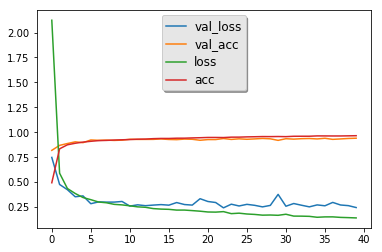

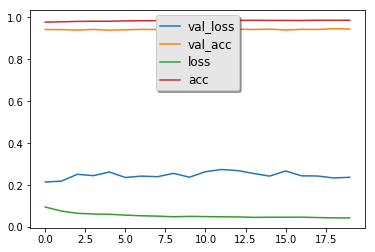

Wall time: 16min 24s


In [5]:
%%time
print("\nTINYDARKNET")
cnn = models.tinyDarknet(x_train,y_train, depth = 3, dropout = 0.15)
#cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/200),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/200), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn4.bak'
cnn.save(dest_directory + name)

In [ ]:
#!tensorboard --logdir Graph/

In [15]:
from keras.layers import Input
from keras.layers import Flatten, Dense, Activation, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
input_img = Input(shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]))

def cBN(name, inputLayer, filt = 64, size = (1,1), padding = 'same', activation = 'relu', regu = 0.0):
    cbn = Conv2D(filt, size, padding=padding, name = name, use_bias=False, kernel_regularizer=regularizers.l2(regu))(inputLayer)
    cbn = BatchNormalization()(cbn)
    cbn = Activation('relu')(cbn)
    return cbn

tower_1 = cBN('tower_11',input_img)   
tower_1 = cBN('tower_12',tower_1, size = (3,3))

tower_2 = cBN('tower_21',input_img)
tower_2 = cBN('tower_22',tower_2, size = (5,5))

tower_3 = MaxPooling2D((3,3), name = 'tower_31', strides=(1,1), padding='same')(input_img)
tower_3 = cBN('tower_32',tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

output = MaxPooling2D(pool_size=(3,2))(output)

tower_1 = cBN('tower_11_2',output)   
tower_1 = cBN('tower_12_2',tower_1, size = (3,3))

tower_2 = cBN('tower_21_2',output)
tower_2 = cBN('tower_22_2',tower_2, size = (5,5))

tower_3 = MaxPooling2D( (3,3),name = 'tower_31_2', strides=(1,1), padding='same')(output)
tower_3 = cBN('tower_32_2',tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

output = MaxPooling2D(pool_size=(2,2))(output)

tower_1 = cBN('tower_11_3',output)   
tower_1 = cBN('tower_12_3',tower_1, size = (3,3))

tower_2 = cBN('tower_21_3',output)
tower_2 = cBN('tower_22_3',tower_2, size = (2,2))

tower_3 = MaxPooling2D( (3,3),name = 'tower_31_3', strides=(1,1), padding='same')(output)
tower_3 = cBN('tower_32_3',tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

output = MaxPooling2D(pool_size=(4,2))(output)

output = Flatten()(output)
output = Dropout(0.2)(output)
output    = Dense(100, activation='relu')(output)
output = Dropout(0.2)(output)
output    = Dense(40, activation='relu')(output)
output = Dropout(0.5)(output)
out    = Dense(y_train.shape[1], activation='softmax')(output)

In [16]:
from keras.models import Model
cnn = Model(inputs = input_img, outputs = out)
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 99, 26, 3)    0                                            
__________________________________________________________________________________________________
tower_11 (Conv2D)               (None, 99, 26, 64)   192         input_4[0][0]                    
__________________________________________________________________________________________________
tower_21 (Conv2D)               (None, 99, 26, 64)   192         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 99, 26, 64)   256         tower_11[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [18]:
sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])
fittedSGD = cnn.fit(x_train, y_train, 
                epochs=60, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/200), 
                shuffle=True,
                callbacks = [tbCallBack])

Train on 40451 samples, validate on 10113 samples
Epoch 1/60
40451/40451 [==============================] - 45s 1ms/step - loss: 0.2420 - acc: 0.9164 - val_loss: 0.2465 - val_acc: 0.9364
Epoch 2/60
40451/40451 [==============================] - 43s 1ms/step - loss: 0.2243 - acc: 0.9222 - val_loss: 0.2360 - val_acc: 0.9401
Epoch 3/60
40451/40451 [==============================] - 42s 1ms/step - loss: 0.2179 - acc: 0.9248 - val_loss: 0.2449 - val_acc: 0.9378
Epoch 4/60
40451/40451 [==============================] - 43s 1ms/step - loss: 0.2093 - acc: 0.9274 - val_loss: 0.2441 - val_acc: 0.9401
Epoch 5/60
40451/40451 [==============================] - 43s 1ms/step - loss: 0.2070 - acc: 0.9276 - val_loss: 0.2334 - val_acc: 0.9392
Epoch 6/60
40451/40451 [==============================] - 43s 1ms/step - loss: 0.2009 - acc: 0.9298 - val_loss: 0.2478 - val_acc: 0.9387
Epoch 7/60
40451/40451 [==============================] - 43s 1ms/step - loss: 0.1960 - acc: 0.9319 - val_loss: 0.2685 - val_acc

KeyboardInterrupt: 

In [17]:
compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/150),
                     shuffle=True,
                     callbacks = [tbCallBack])

Train on 40451 samples, validate on 10113 samples
Epoch 1/40
40451/40451 [==============================] - 45s 1ms/step - loss: 2.2741 - acc: 0.2101 - val_loss: 1.8687 - val_acc: 0.3461
Epoch 2/40
40451/40451 [==============================] - 42s 1ms/step - loss: 1.5367 - acc: 0.4360 - val_loss: 1.1886 - val_acc: 0.6179
Epoch 3/40
40451/40451 [==============================] - 42s 1ms/step - loss: 1.0755 - acc: 0.6161 - val_loss: 0.6488 - val_acc: 0.7957
Epoch 4/40
40451/40451 [==============================] - 42s 1ms/step - loss: 0.8704 - acc: 0.6946 - val_loss: 0.6726 - val_acc: 0.7832
Epoch 5/40
40451/40451 [==============================] - 42s 1ms/step - loss: 0.7573 - acc: 0.7414 - val_loss: 0.4214 - val_acc: 0.8734
Epoch 6/40
40451/40451 [==============================] - 42s 1ms/step - loss: 0.6738 - acc: 0.7751 - val_loss: 0.4916 - val_acc: 0.8424
Epoch 7/40
40451/40451 [==============================] - 42s 1ms/step - loss: 0.6154 - acc: 0.7986 - val_loss: 0.3449 - val_acc

KeyboardInterrupt: 

# Score

In [ ]:
#find prediction with test data
preds = cnn.predict(x_test)
print(list(used))

#plot confusion matrix
functions.plotConfusionMatrix(preds,y_test,list(used))
loss, precision = cnn.evaluate(x_test,y_test)
print ("Precision: ", round(precision*100,2),"%")

In [ ]:
fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.show()
    

# Output of conv2D

In [ ]:
cnn_copy = Sequential()
cnn_copy.add(cnn.layers[0])
result = cnn_copy.predict(x_test)


In [ ]:
plt.figure()
plt.imshow(result[0,:,:,0])

# Save Model

In [ ]:
dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)
name = 'cnn.bak'
cnn.save(dest_directory + name)

#bak = load_model(dest_directory + name)


In [ ]:
model = Model(input_shape=(x_train.shape[1], x_train.shape[2],1))
model.add(Conv2D(100, (4,4),  strides = (1,1), padding="valid"))
model.add(Conv2D(100, (4,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(3,3)))
model.add(Conv2D(128, (4,2),  strides = (1,1), padding="valid"))
model.add(Conv2D(128, (5,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(4,1)))
model.add(Flatten_drawer())
model.add(Dense_drawer(100))
model.add(Dense_drawer(y_train.shape[1]))

#save to pdf
save_model_to_file(model, "example.pdf")

# Looking for hyperparameters

In [ ]:
from keras.activations import softmax
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
trials = Trials()
best_run, best_model = optim.minimize(model=functions.create_model, 
                                      data=functions.data,
                                      algo=tpe.suggest,
                                      max_evals=100,
                                      trials=trials,
                                      notebook_name='Processing')

In [ ]:
dest_directory = 'model_backup/'
'''
best_model = load_model(dest_directory + 'best_model.bak')

with open(dest_directory+'best_run.pkl', 'rb') as f:  
    best_run = pickle.load(f)    
'''
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.summary()




now = datetime.datetime.now()
dest_directory_temp =dest_directory + 'bestModel('+now.strftime("%m-%d %H.%M")+")"
if not os.path.exists(dest_directory_temp):
      os.makedirs(dest_directory_temp)
best_model.save(dest_directory_temp + '/best_model.bak')

with open(dest_directory_temp + '/best_run.pkl', 'wb') as f:  
    pickle.dump(best_run, f)



In [ ]:
trials.best_trial